This code implements the Bacon Barnett and Scattergood Fourier-transform approach to computing a general elastic Green's function and its derivative.

In [1]:
using LinearAlgebra, Printf, LaTeXStrings, Random, Distributions

In [2]:
import Plots, PyPlot

In [3]:
# Functions to convert Voigt indices to normal indices in 2D and 3D.
# (For convenience of constructing tensors from the literature)

function Voigt3D(ij)
    if ij[1]==ij[2]
        return ij[1]
    elseif (ij[1]==2 && ij[2]==3) | (ij[1]==3 && ij[2]==2)
        return 4;
    elseif (ij[1]==3 && ij[2]==1) | (ij[1]==1 && ij[2]==3)
        return 5;
    elseif (ij[1]==1 && ij[2]==2) | (ij[1]==2 && ij[2]==1)
        return 6;
    else
        error("Invalid 3D index pair")
    end
end

function Voigt3DInv(i)
    if i==1
        return [1 1];
    elseif i==2
        return [2 2];
    elseif i==3
        return [3 3];
    elseif i==4
        return [2 3];
    elseif i==5
        return [1 3];
    elseif i==6
        return [1 2];
    else
        error("Invalid 3D Voigt index")
    end
end

function Voigt2D(ij)
    if ij[1]==ij[2]
        return ij[1]
    elseif (ij[1]==1 && ij[2]==2) | (ij[1]==2 && ij[2]==1)
        return 3;
    else
        error("Invalid 2D index pair")
    end
end

function Voigt2DInv(i)
    if i==1
        return [1 1];
    elseif i==2
        return [2 2];
    elseif i==3
        return [1 2];
    else
        error("Invalid 2D Voigt index")
    end
end

Voigt2DInv (generic function with 1 method)

In [4]:
#---------------Functions for the Green tensor and their gradients in the general case and isotropic case: -------------------------
"""
* `GreenTensor3D(x::vector,C::Tensor,n::Int) -> G::Tensor`
Computes the full 3D Green tensor at the point x for elasticity
tensor ℂ ∈ ℝ³ˣ³ˣ³ˣ³.
"""
function GreenTensor3D(x,ℂ,n)
    # Error handling (NB: this should not be necessary once we define types correctly.)
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    elseif ~( size(ℂ)==(3,3,3,3) )
        error("Elasticity tensor incorrect size");
    end
        
    G = zeros(Float64,3,3);
    # basis is a 3x2 matrix of vectors orthogonal to x.
    basis = nullspace(x');
    for m=0:n-1
        zz = zeros(Float64,3,3);
        z = basis*[cos(pi*m/n); sin(pi*m/n)];
        for i=1:3, j=1:3
            for k=1:3, l=1:3
                zz[i,j] += z[k]*ℂ[i,k,j,l]*z[l];
            end
        end
        zzinv = inv(zz)
        G += zzinv;
    end
    G = G/(4*pi*norm(x)*n)
    return G
end

"""
* `GradGreenTensor3D(x::vector,C::Tensor,n::Int) -> DG::Tensor`
Computes the gradient of the 3D Green tensor at the point x for elasticity
tensor ℂ ∈ ℝ³ˣ³ˣ³ˣ³.
"""
function GradGreenTensor3D(x,ℂ,n)
    # Error handling (NB: this should not be necessary once we define types correctly.)
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    elseif ~( size(ℂ)==(3,3,3,3) )
        error("Elasticity tensor incorrect size");
    end
    
    # Initialise tensors.
    DG = zeros(Float64,3,3,3);
    T = x/norm(x);
    F = zeros(Float64,3,3);
    
    # Basis is a 3x2 matrix of vectors orthogonal to x.
    basis = nullspace(x'); #<---- Code in more explicit basis vectors for x
    
    
    # Integrate
    for m=0:n-1
        zz = zeros(Float64,3,3);
        zT = zeros(Float64,3,3);
        z = basis*[cos(2*pi*m/n); sin(2*pi*m/n)];
        for i=1:3, j=1:3, r=1:3, s=1:3
            zz[i,j] += z[r]*ℂ[i,r,j,s]*z[s];
            zT[i,j] += z[r]*ℂ[i,r,j,s]*T[s];
        end
        zzinv = inv(zz);
        F = (zz\(zT+zT'))/zz;
        for i=1:3, j=1:3, k=1:3
            DG[i,j,k] += T[k]*zzinv[i,j]-z[k]*F[i,j];
        end
    end
    DG = -DG/(4*pi*norm(x)^2*n)
    
    #DG = real.(DG)
    #contains_dual = any(y -> isa(y, ForwardDiff.Dual), DG)
    #println("Dual elements: ", contains_dual, "\n")
    return DG
end

"""
* `GreenTensor3DIso(x::vector,μ::Float64,λ::Float64) -> G::Tensor`
Returns the 3D Isotropic Green tensor at the point x via exact formula
with Lamé parameters μ and λ.
"""
function GreenTensor3DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    end
        
    G = ((λ+3*μ)/(λ+2*μ)*I(3)/norm(x)+(λ+μ)/(λ+2*μ)*x*x'/norm(x)^3)/(8*pi*μ);
    
    return G
end

"""
* `GradGreenTensor3DIso(x::vector,μ::Float64,λ::Float64,n::Int) -> DG::Tensor`
Computes the gradient of the 3D Green tensor at the point x for an Isotropic
elasticity tensor with Lamé parameters μ and λ.
"""
function GradGreenTensor3DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    end
    
    DG = zeros(Float64,3,3,3);
    Id = I(3);
    
    for i=1:3, j=1:3, k=1:3
            DG[i,j,k] = ( (λ+μ)*(Id[i,k]*x[j]+Id[j,k]*x[i]) - (λ+3*μ)*I(3)[i,j]*x[k] ) -
                            3*(λ+μ)*x[i]*x[j]*x[k]/(norm(x)^2);
    end
    DG = DG/(8*pi*μ*(λ+2*μ)*norm(x)^3);
    
    return DG
end



GradGreenTensor3DIso

In [5]:
#---------------2D Isotropic Green tensor: ----------------
"""
* `GreenTensor2DIso(x::vector,μ::Float64,λ::Float64) -> G::Tensor`
Returns the 2D Isotropic Green tensor at the point x via exact formula
with Lamé parameters μ and λ.
"""
function GreenTensor2DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(2,) ) && ~( size(x)==(2,1) )
        error("Input is not a 3D column vector");
    end
        
    G = ((λ+μ)*x*x'/norm(x)^2-(λ+3*μ)*I(2)*log(norm(x)))/(4*pi*μ*(λ+2*μ));
    
    return G
end

GreenTensor2DIso

In [6]:
#--------------------Finite difference method to calculating strain for the Green tensor functions: -----------------------

function calculate_jacobian_Iso(u_func, x, ℂ, burgers, nu, R, delta_x)
    n = length(x);
    m = length(u_func(x, ℂ, burgers, nu, R));
    
    jacobian_matrix = zeros(Float64, m, n);
    
    for i in 1:n
        x_plus_dx = copy(x);
        x_plus_dx[i] += delta_x;
        
        x_minus_dx = copy(x);
        x_minus_dx[i] -= delta_x;
        
        jacobian_matrix[:, i] = (u_func(x_plus_dx, ℂ, burgers, nu, R) - u_func(x_minus_dx, ℂ, burgers, nu, R)) / (2.0 * delta_x);
    end
    
    return jacobian_matrix
end

function calculate_jacobian(u_func, x, ℂ, burgers, nu, R, delta_x, quad)
    n = length(x);
    m = length(u_func(x, ℂ, burgers, nu, R, quad));
    
    jacobian_matrix = zeros(Float64, m, n);
    
    for i in 1:n
        x_plus_dx = copy(x);
        x_plus_dx[i] += delta_x;
        
        x_minus_dx = copy(x);
        x_minus_dx[i] -= delta_x;
        
        jacobian_matrix[:, i] = (u_func(x_plus_dx, ℂ, burgers, nu, R, quad) - u_func(x_minus_dx, ℂ, burgers, nu, R, quad)) / (2.0 * delta_x);
    end
    
    return jacobian_matrix
end

function hookes_law(strain, ℂ)
    stress = zeros(Float64, 3, 3);
    for i=1:3, j=1:3, k=1:3, l=1:3
       stress[i, j] += ℂ[i, j, k, l] * strain[k, l];
    end
    return stress
end

hookes_law (generic function with 1 method)

In [8]:
#--------------------------------Displacement field predictions using Green's Tensor: -----------------------------

#-------------------------------------------------------------------------------------------------
# Leading order term:

# Displacement using the explicit isotropic expression for the gradient of the Green's tensor:
function u_disp_green_Iso(x, ℂ, burgers, nu, R)
    DG = GradGreenTensor3DIso(x,μ,λ);
    u_green = zeros(Float64,3);
    for α=1:3, β=1:3, p=1:3, q=1:3, r=1:3
        u_green[α] += ℂ[β, p, q, r] * burgers[q] * nu[r] * DG[β, α, p] * pi * R^2;
    end
    return u_green
end

# Displacement for a general Green's tensor (need not be isotropic):
function u_disp_green(x, ℂ, burgers, nu, R, n)
    DG = GradGreenTensor3D(x, ℂ, n);
    u_green = zeros(Float64,3);
    for α=1:3, β=1:3, p=1:3, q=1:3, r=1:3
        u_green[α] += ℂ[β, p, q, r] * burgers[q] * nu[r] * DG[β, α, p] * pi * R^2;
    end
    return u_green
end

#-----------------------------------------------------------------------------------------------

u_disp_green (generic function with 1 method)

In [9]:
#-----------------Function to calculate the middle principal stress: --------------------------------
function middle_eigenvalue(matrix)
    eigenvalues = eigvals(matrix)
    sorted_eigenvalues = sort(eigenvalues)
    middle_index = div(length(sorted_eigenvalues), 2) + 1
    middle_eigenvalue = sorted_eigenvalues[middle_index]
    return middle_eigenvalue
end

middle_eigenvalue (generic function with 1 method)

In [125]:
#Uncertainty Propagation-setting up parameters:

#=============================================FIXED PARAMETERS===============================================#
#-----------------Orientation of measuring position with respect to dislocation centre------------------------
phi = pi/4;
theta = pi/2;
#-------------------------------------------------------------------------------------------------------------

# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;
#-----------------------------------------Radii array: -------------------------------------------------------
radii = range(11*a, 60*a, length=50);
#-------------------------------------------------------------------------------------------------------------

# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu_1 = [1.0, 1.0, 0.0];
#Normal unit vector:
nu = nu_1 / norm(nu_1);
delta_x = 1e-6;
#============================================================================================================#

# Setting up elastic moduli distributions:
seed = Random.seed!(1000);
shearModDist = Normal(145e9, 15e9);
lammeMean = (2*145e9*0.28)/(1 - 2*0.28);
lammeStd = (2*15e9*0.01)/(1 - 2*0.01);
lammeParamDist = Normal(lammeMean, lammeStd);

# Sampling elastic moduli:
numSamples = 500; #<-------------- The number of samples used.
shearMods = rand(shearModDist, numSamples);
lammeParams = rand(lammeParamDist, numSamples);

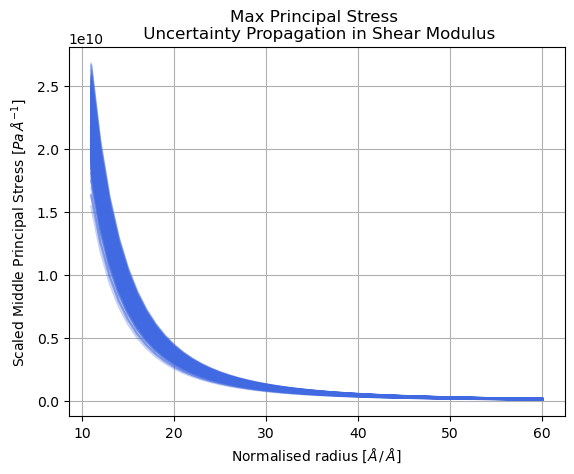

In [126]:
# Propagating uncertainty in shear modulus:
for i in range(1,numSamples, step=1)
    μ = shearMods[i];
    λ = lammeMean;
    #λ = lammeParams[i];
    maxPrincipals = Array{Float64,1}(undef, size(radii)[1]);
    j = 1;
    for r in radii
       pos = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
        CVoigt3D = [λ+2*μ  λ      λ      0   0   0;
                    λ      λ+2*μ  λ      0   0   0;
                    λ      λ      λ+2*μ  0   0   0;
                    0      0      0      μ   0   0;
                    0      0      0      0   μ   0;
                    0      0      0      0   0   μ];
        # Convert to full elasticity tensor.
        C3D = zeros(3,3,3,3);
        for i=1:3, j=1:3, k=1:3, l=1:3
            C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
        end
       strain = calculate_jacobian(u_disp_green, pos, C3D, burgers, nu, R, delta_x, 30);
       stress = hookes_law(strain, C3D);
       maxP = eigmax(stress);
       maxPrincipals[j] = maxP; 
       j = j + 1;
    end
    PyPlot.plot(radii, maxPrincipals, "-", color="royalblue", alpha=0.3);
end
PyPlot.title("Max Principal Stress \n Uncertainty Propagation in Shear Modulus");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropShear.png", dpi=300);

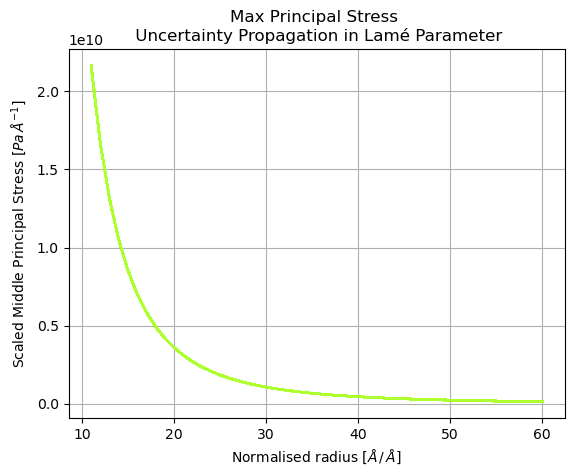

In [123]:
# Propagating uncertainty in lamme parameter:
for i in range(1,numSamples, step=1)
    μ = 145e9;
    λ = lammeParams[i];
    maxPrincipals = Array{Float64,1}(undef, size(radii)[1]);
    j = 1;
    for r in radii
       pos = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
        CVoigt3D = [λ+2*μ  λ      λ      0   0   0;
                    λ      λ+2*μ  λ      0   0   0;
                    λ      λ      λ+2*μ  0   0   0;
                    0      0      0      μ   0   0;
                    0      0      0      0   μ   0;
                    0      0      0      0   0   μ];
        # Convert to full elasticity tensor.
        C3D = zeros(3,3,3,3);
        for i=1:3, j=1:3, k=1:3, l=1:3
            C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
        end
       strain = calculate_jacobian(u_disp_green, pos, C3D, burgers, nu, R, delta_x, 30);
       stress = hookes_law(strain, C3D);
       maxP = eigmax(stress);
       maxPrincipals[j] = maxP;
       j = j + 1;
    end
    PyPlot.plot(radii, maxPrincipals, "-", color="greenyellow", alpha=0.3);
end
PyPlot.title("Max Principal Stress \n Uncertainty Propagation in Lamé Parameter");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropLame.png", dpi=300);

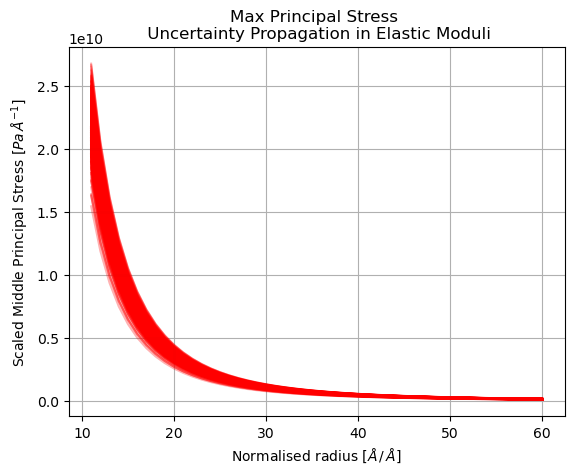

In [127]:
# Propagating uncertainty in both elastic moduli:
maxPrincipals = Array{Float64}(undef, size(radii)[1], numSamples);
meanMaxP = Array{Float64}(undef, size(radii)[1]);
varMaxP = Array{Float64}(undef, size(radii)[1]);
stdMaxP = Array{Float64}(undef, size(radii)[1]);
for i in range(1,numSamples, step=1)
    μ = shearMods[i];
    λ = lammeParams[i];
    j = 1;
    for r in radii
       pos = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
        CVoigt3D = [λ+2*μ  λ      λ      0   0   0;
                    λ      λ+2*μ  λ      0   0   0;
                    λ      λ      λ+2*μ  0   0   0;
                    0      0      0      μ   0   0;
                    0      0      0      0   μ   0;
                    0      0      0      0   0   μ];
        # Convert to full elasticity tensor.
        C3D = zeros(3,3,3,3);
        for i=1:3, j=1:3, k=1:3, l=1:3
            C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
        end
       strain = calculate_jacobian(u_disp_green, pos, C3D, burgers, nu, R, delta_x, 30);
       stress = hookes_law(strain, C3D);
       maxP = eigmax(stress);
       maxPrincipals[j, i] = maxP; 
       j = j + 1;
    end
    PyPlot.plot(radii, maxPrincipals[:, i], "-", color="red", alpha=0.3);
end
# Calculate the mean of the max principal for each radial distance.
j = 1;
for r in radii
    meanMaxP[j] = mean(maxPrincipals[j, :]);
    j = j + 1; 
end
# Calculate the variance of the max principal for each radial distance.
j = 1
for r in radii
    varMaxP[j] = sum((maxPrincipals[j, :] .- meanMaxP[j]).^2)/(size(maxPrincipals[j, :])[1] - 1);
    j = j + 1;
end
stdMaxP = sqrt.(varMaxP);

PyPlot.title("Max Principal Stress \n Uncertainty Propagation in Elastic Moduli");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropTotal.png", dpi=300);

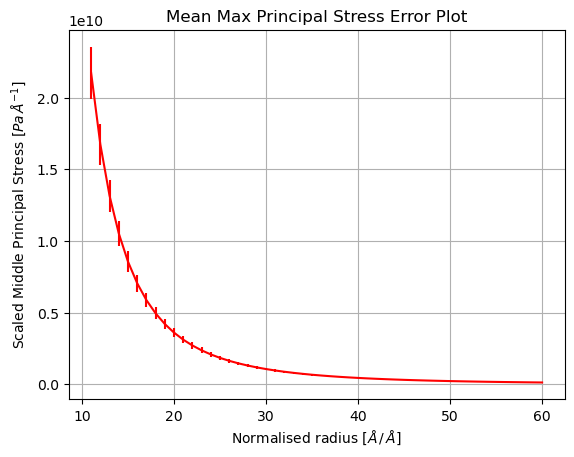

In [128]:
PyPlot.errorbar(radii, meanMaxP, yerr=stdMaxP, fmt="-", color="red", alpha=1);
PyPlot.title("Mean Max Principal Stress Error Plot")
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropMean.png", dpi=300);

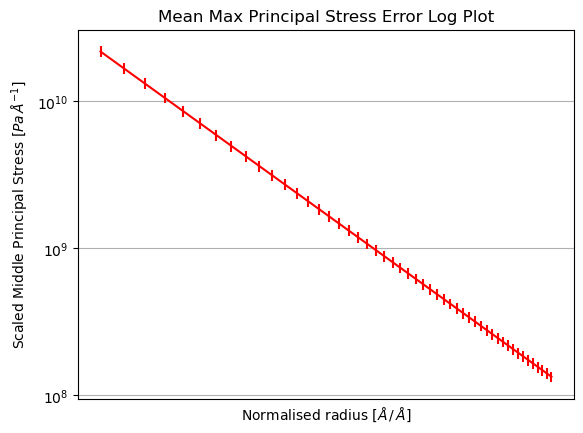

In [129]:
PyPlot.errorbar(radii, meanMaxP, yerr=stdMaxP, fmt="-", color="red", alpha=1);
PyPlot.title("Mean Max Principal Stress Error Log Plot")
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.savefig("unceratintyPropMean-Log.png", dpi=300);

In [130]:
@printf("Mean value of the maximum principal stress at a radius of r=%.1f a is: %.3e Pa, with an error of %.3e Pa. \n", radii[10], meanMaxP[10], stdMaxP[10]);
print("\n");

Mean value of the maximum principal stress at a radius of r=20.0 a is: 3.616e+09 Pa, with an error of 3.051e+08 Pa. 

